![](https://i.ibb.co/HN3DwnS/gan.png)

## Stage 1: Installing dependencies and environement setup

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

## Stage 2: Importing project dependencies

In [0]:
import os
import PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow.keras.datasets import mnist

%matplotlib inline
tf.__version__

'2.0.0-alpha0'

## Stage 3: Dataset preprocessing

### Loading the dataset

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [0]:
X_test =  X_test / 127.5 - 1.
X_train =  X_train / 127.5 - 1.

## Stage 4: Building the DC-GAN


### The generator network

In [0]:
def build_generator(latent_space):

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Dense(128 * 7 * 7, activation="relu", input_dim=latent_space))
  model.add(tf.keras.layers.Reshape((7, 7, 128)))
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(128, kernel_size=3, padding="same"))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  model.add(tf.keras.layers.Activation("relu"))
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(64, kernel_size=3, padding="same"))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  model.add(tf.keras.layers.Activation("relu"))
  model.add(tf.keras.layers.Conv2D(1, kernel_size=3, padding="same"))
  model.add(tf.keras.layers.Activation("tanh"))

  model.summary()

  noise = tf.keras.layers.Input(shape=(latent_space,))
  img = model(noise)

  return tf.keras.models.Model(noise, img)

### The discriminator network

In [0]:
def build_discriminator():

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, input_shape=[28, 28, 1], padding="same"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.summary()

    img = tf.keras.layers.Input(shape=[28, 28, 1])
    validity = model(img)

    return tf.keras.models.Model(img, validity)

## Step 5: Training the GAN

### Optimizer setup

In [0]:
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

### Defining the discriminator

In [0]:
discriminator = build_discriminator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

### Compiling the discriminator

In [0]:
discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

### Defining the generator

In [0]:
generator = build_generator(100)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 14, 14, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)      

In [0]:
# The generator takes noise as input and generates imgs
z = tf.keras.layers.Input(shape=(100,))
img = generator(z)

### Making of GAN

In [0]:
# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

In [0]:
gan = tf.keras.models.Model(z, valid)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [0]:
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         856193    
_________________________________________________________________
model (Model)                (None, 1)                 393729    
Total params: 1,249,922
Trainable params: 855,809
Non-trainable params: 394,113
_________________________________________________________________


### Simple training loop

In [0]:
epochs = 4000
batch_size = 200

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [0]:
for epoch in range(epochs):
  
    # Select a random half of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx].reshape(-1, 28, 28, 1)

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = gan.train_on_batch(noise, valid)

    # Plot the progress
    print ("Disc loss: {}  ||  Generator loss: {}".format(d_loss[0], g_loss))

W0617 11:37:10.456792 140688551032704 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0617 11:37:13.074649 140688551032704 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Disc loss: 0.9713159799575806  ||  Generator loss: 0.5140295624732971
Disc loss: 0.5099446177482605  ||  Generator loss: 0.7158921957015991
Disc loss: 0.5715621709823608  ||  Generator loss: 1.1932382583618164
Disc loss: 0.6734564900398254  ||  Generator loss: 1.7284339666366577
Disc loss: 0.7245947122573853  ||  Generator loss: 1.8390676975250244
Disc loss: 0.6059420108795166  ||  Generator loss: 1.7666325569152832
Disc loss: 0.5874351263046265  ||  Generator loss: 1.3753225803375244
Disc loss: 0.5572882294654846  ||  Generator loss: 1.330997109413147
Disc loss: 0.6098368167877197  ||  Generator loss: 1.2196465730667114
Disc loss: 0.5415959358215332  ||  Generator loss: 1.1850649118423462
Disc loss: 0.5410703420639038  ||  Generator loss: 1.3826727867126465
Disc loss: 0.46828049421310425  ||  Generator loss: 1.3760567903518677
Disc loss: 0.43700242042541504  ||  Generator loss: 0.990965723991394
Disc loss: 0.560344934463501  ||  Generator loss: 0.915446937084198
Disc loss: 0.864530682

### Generating images with GAN

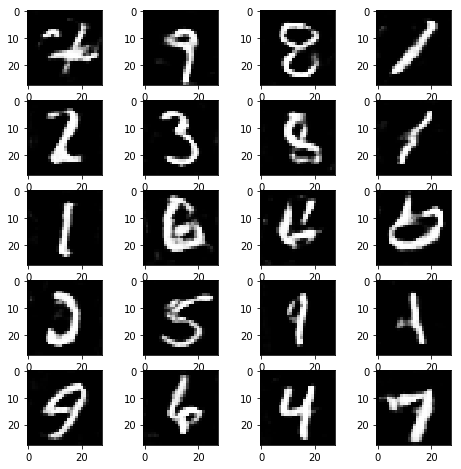

In [0]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = generator.predict(np.random.normal(0, 1, (1, 100)))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img[0].reshape(28, 28), cmap='gray')
plt.show()